In [1]:
import h5py

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
FILE_NAME = "../data/RUN000054_data.txt"

In [3]:
stream_df = pd.read_csv(FILE_NAME)
stream_df.head()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,2,0,35,1379482729,2693,11
1,2,0,56,1379482738,3051,1
2,2,1,122,1379482739,567,12
3,2,0,98,1379482743,3196,23
4,2,0,101,1379482743,3201,13


In [19]:
len(stream_df)

53784258

In [4]:
import yaml
with open("../config/RUN000054.yml", 'r') as stream:
    cfg = yaml.safe_load(stream)


In [5]:
# select all hits in the stream from the scintillator channel
trigger_df = stream_df[
    (stream_df['HEAD'] == cfg['scintillator']['head']) & 
    (stream_df['FPGA'] == cfg['scintillator']['fpga']) & 
    (stream_df['TDC_CHANNEL'] == cfg['scintillator']['tdc_ch'])
].copy()


In [6]:

# create a T0 column (in ns)
trigger_df['T0'] = (trigger_df['BX_COUNTER'] + trigger_df['TDC_MEAS'] / 30)*25

""""
# trigger words and scintillator hits are removed
hits_df = stream_df[
        (stream_df.HEAD == cfg["headers"]["valid_hit"]) &
        (stream_df.TDC_CHANNEL <= 127)
        ].copy()
"""

'"\n# trigger words and scintillator hits are removed\nhits_df = stream_df[\n        (stream_df.HEAD == cfg["headers"]["valid_hit"]) &\n        (stream_df.TDC_CHANNEL <= 127)\n        ].copy()\n'

In [7]:

# join trigger table to the dataframe with valid hits
hits_df = pd.merge(
        stream_df, trigger_df[['ORBIT_CNT','T0']],
        left_on='ORBIT_CNT', right_on='ORBIT_CNT',
        suffixes=(None, None)
)

In [8]:
hits_df = hits_df[
        (hits_df.HEAD == cfg["headers"]["valid_hit"]) &
        (hits_df.TDC_CHANNEL <= 127)
        ]

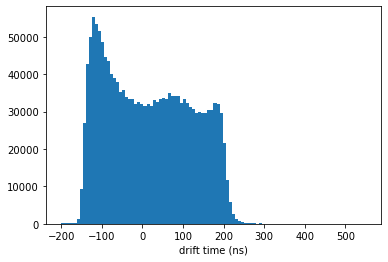

In [9]:
plt.hist(
    ((hits_df['BX_COUNTER']+hits_df['TDC_MEAS']/30)*25 - hits_df['T0']),
    range=(-200,550), bins=100
    )
plt.xlabel('drift time (ns)')
plt.show()

## Fit the right _time_offset_scint_

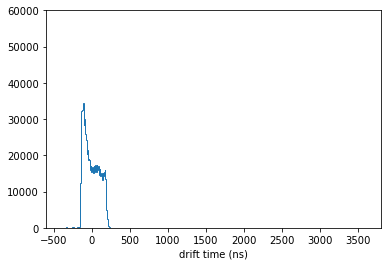

In [26]:
counts, bins, _ = plt.hist(
    ((hits_df['BX_COUNTER']+hits_df['TDC_MEAS']/30)*25 - hits_df['T0']),
    range=(-400,3600), bins=500, histtype=u'step'
    )
plt.xlabel('drift time (ns)')
#plt.xlim(-200, -100)
plt.ylim(0,60000)
plt.show()

In [27]:
from scipy.special import erf
import numpy as np
from scipy.optimize import curve_fit

def fit_edge(t, I, t_mean, sigma):
    return 0.5*I*(1+erf((t-t_mean)/(np.sqrt(2)*sigma)))

In [25]:
hits_df["SL"]= (hits_df["TDC_CHANNEL"]+128*hits_df["FPGA"])//64
hits_df["SL"][hits_df["SL"]<2] = [int(not x) for x in hits_df["SL"]]

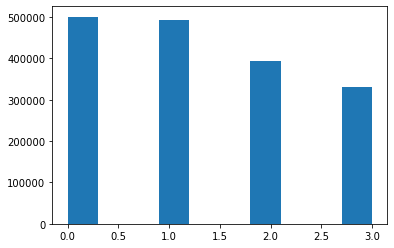

In [26]:
plt.hist(hits_df['SL'])
plt.show()

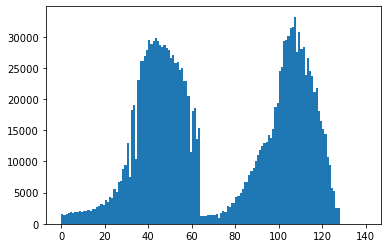

In [27]:
plt.hist(hits_df['TDC_CHANNEL'], range = (0,140), bins = 140)
plt.show()

In [52]:
hits_df_ = hits_df[hits_df['SL']==3] # modify to select specific SLs

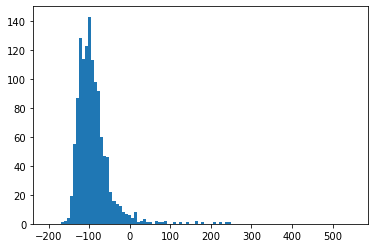

In [53]:
plt.hist((hits_df_['BX_COUNTER']+hits_df_['TDC_MEAS']/30)*25 - hits_df_['T0'], range=(-200,550), bins=100)
plt.show()

/home/gfrances/miniconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:756: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/home/gfrances/miniconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:488: RuntimeWarning: invalid value encountered in multiply
  return transform * (func(xdata, *params) - ydata)
/home/gfrances/miniconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


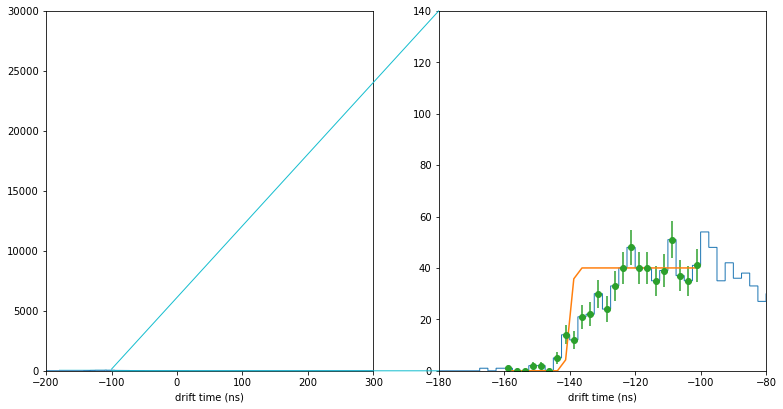

In [57]:
from matplotlib.patches import ConnectionPatch

fig = plt.figure(figsize=(10, 5))
plt.subplots_adjust(bottom = 0., left = 0, top = 1., right = 1)

n_bins = 1600
height = 140#25000

sub1 = fig.add_subplot(1,2,1) 
sub1.hist(
    ((hits_df_['BX_COUNTER']+hits_df_['TDC_MEAS']/30)*25 - hits_df_['T0']),
    range=(-400,3600), bins=n_bins, histtype=u'step'
    )
sub1.set_ylim(0,30000)
sub1.set_xlim(-200,300)
sub1.set_xlabel('drift time (ns)')

sub2 = fig.add_subplot(1,2,2)

# hist
counts, bins, _ = sub2.hist(
    ((hits_df_['BX_COUNTER']+hits_df_['TDC_MEAS']/30)*25 - hits_df_['T0']),
    range=(-400,3600), bins=n_bins, histtype=u'step'
    )

# get fit points
x_points = np.array([(x1+x2)*0.5 for x1, x2 in zip(bins[:-1], bins[1:])])
err      = np.array([np.sqrt(n) for n in counts])
counts   = np.array(counts)
idx      = np.array([ i for i in range(len(x_points)) if(-160<x_points[i]<-100)])#20)])
x_points = x_points[idx]
err      = err[idx]
counts   = counts[idx]

# fit
#p0 = [20000, -140, 1]
p0 = [40, -140, 1]
popt, pcov = curve_fit(fit_edge, x_points, counts, p0, err)

#plot
sub2.plot(x_points, fit_edge(x_points, *popt))
sub2.errorbar(x_points, counts, err, fmt='o')
sub2.set_xlim(-180,-80)
sub2.set_ylim(0,height)
sub2.set_xlabel('drift time (ns)')

# decorations
sub1.fill_between((-180,-100), 0, height, facecolor='tab:cyan', alpha=0.2)

con1 = ConnectionPatch(xyA=(-100, height), coordsA=sub1.transData, 
                       xyB=(-180, height), coordsB=sub2.transData, color = 'tab:cyan')
fig.add_artist(con1)

con2 = ConnectionPatch(xyA=(-100, 0), coordsA=sub1.transData, 
                       xyB=(-180, 0), coordsB=sub2.transData, color = 'tab:cyan')
fig.add_artist(con2)

In [58]:
popt[1]+144.35

4.349999999999994

In [10]:
import sys

sys.path.append('../dataset_script')

In [11]:
import importlib
import reco
importlib.reload(reco)

<module 'reco' from '/mnt/c/Users/giaco/Il mio Drive/Uni/Physics of data/LCP/LCP_modA_finalProject/data_analysis/../dataset_script/reco.py'>

In [12]:
import pandas as pd
import numpy as np
import yaml
import math
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore")

# CONSTANTS
USE_TRIGGER = False
RUN_TIME_SHIFT = 0
KEEP = ["FPGA", "TDC_CHANNEL", "HIT_DRIFT_TIME", "D_WIRE_HIT", "m"]

from eventsFactory import getEvents
from reco import getRecoResults
def buildDataframe(stream_df, cfg):

    df = pd.DataFrame()

    # reco (da sistemare getEvents e getRecoResults)
    print("Getting events...")
    events = getEvents(stream_df, cfg, RUN_TIME_SHIFT, USE_TRIGGER)
    print("Reconstructing tracks...")
    resultsList, resultsData, resultsHits, resultsDf = getRecoResults(
        events, USE_TRIGGER
    )
    print("Building dataframe...")
    # out df
    for df_ in resultsDf:
        df_['D_WIRE_HIT']= df_['X']-df_['WIRE_X_GLOB']
        df_ = df_[KEEP]
        df = pd.concat([df, df_], axis=0, ignore_index=True)

    # add a sequential channel tag
    df.loc[(df["FPGA"] == 0), "CH"] = df["TDC_CHANNEL"]
    df.loc[(df["FPGA"] == 1), "CH"] = df["TDC_CHANNEL"] + 128
    df_ = df.drop(["FPGA", "TDC_CHANNEL"], axis=1)
    df_["CH"] = df_["CH"].astype(np.uint32)

    # clean dataset
    df = df_[["CH", "HIT_DRIFT_TIME",'D_WIRE_HIT', "m"]]
    df = df[(df["HIT_DRIFT_TIME"] > -200) & (df["HIT_DRIFT_TIME"] < 600)]
    df = df[(df['D_WIRE_HIT'] > -21) & (df['D_WIRE_HIT'] < 21)]

    # rad to deg conversion
    df["THETA"] = np.arctan(df["m"]) * 180.0 / math.pi

    print("Dataframe ready!")

    return df, resultsList, resultsData, resultsHits, resultsDf

In [19]:
upper_bound = 500000
df, resultsList, resultsData, resultsHits, resultsDf = buildDataframe(stream_df[:upper_bound], cfg)

Getting events...
Valid hits: 7354
Reconstructing tracks...
Building dataframe...
Dataframe ready!


In [20]:
x_residuals = [[] for i in range(4)]
d_wire_hit  = [[] for i in range(4)]
for i in range(len(resultsDf)):
    if( resultsHits[i].df is None ): continue

    # loop over SL
    for sl in resultsList[i]['SL']:
        df = resultsDf[i][resultsDf[i]['SL']==sl]
        x_residuals[sl].extend(df['X']-(df['WIRE_Z_GLOB']*df['m']+df['q']))
        d_wire_hit[sl].extend(abs(df['X']-df['WIRE_X_GLOB']))



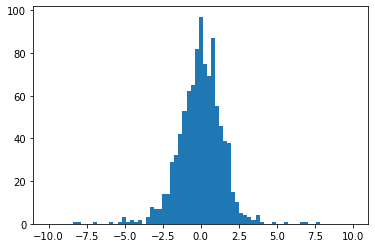

In [24]:
plt.hist(x_residuals[3], range=(-10, 10), bins = 75)
plt.show()

(-15.0, 15.0)

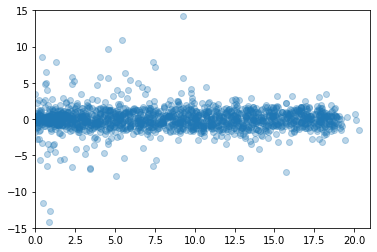

In [28]:
plt.scatter(d_wire_hit[0], x_residuals[0], alpha=0.3)
plt.xlim(0,21)
plt.ylim(-15,15)

In [31]:
np.mean(x_residuals[3])

6.916541190474234e-08

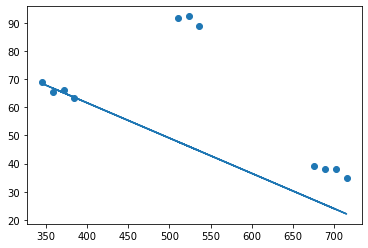

In [100]:
plt.scatter(df_true['Z'], df_true['X'])
plt.plot(df_true['Z'], df_true['Z']*resultsList[0]['m'][0]+resultsList[0]['q'][0])